This notebook performs a finetuning of hgraph2graph model on new data.

To run the notebook:
1. Extract SMILES from sensitivity table using `gmm-vae-compounds/utils/utils.sensitivity_table_to_smiles_representation` and
    save it to `gmm-vae-compounds/models/hgraph2graph/data/vadeers`.
2. Supply `gmm-vae-compounds/models/hgraph2graph/data/vadeers` with a vocabulary.

Note that in this notebook hyperparameters were changed to fit into GPU's memory.



In [1]:
import os
os.chdir('/home/adam/Projects/vadeers/code/gmm-vae-compounds/models/hgraph2graph/')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

import math, random, sys
import numpy as np
import argparse
import os
from tqdm.auto import tqdm


import models.hgraph2graph.hgraph
from models.hgraph2graph.hgraph import HierVAE, common_atom_vocab, PairVocab
#from chemprop.train import predict
##from models.hgraph2graph.hgraph.chemprop.data import MoleculeDataset, MoleculeDataLoader
#from models.hgraph2graph.hgraph.chemprop.data.utils import get_data, get_data_from_smiles
#from models.hgraph2graph.hgraph.chemprop.utils import load_args, load_checkpoint, load_scalers


param_norm = lambda m: math.sqrt(sum([p.norm().item() ** 2 for p in m.parameters()]))
grad_norm = lambda m: math.sqrt(sum([p.grad.norm().item() ** 2 for p in m.parameters() if p.grad is not None]))

/home/adam/miniconda3/envs/hgraph2graph/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

parser = argparse.ArgumentParser()
parser.add_argument('--train', default='data/vadeers/smiles.txt')
parser.add_argument('--vocab', default='data/chembl/vocab.txt')
parser.add_argument('--atom_vocab', default=common_atom_vocab)
parser.add_argument('--save_dir', default='ckpt/finetune')
parser.add_argument('--generative_model', default='ckpt/chembl-pretrained/model.ckpt')
#parser.add_argument('--chemprop_model', required=True)
parser.add_argument('--seed', type=int, default=7)

parser.add_argument('--rnn_type', type=str, default='LSTM')
parser.add_argument('--hidden_size', type=int, default=250)
parser.add_argument('--embed_size', type=int, default=250)
parser.add_argument('--batch_size', type=int, default=2)
parser.add_argument('--latent_size', type=int, default=32)
parser.add_argument('--depthT', type=int, default=15)
parser.add_argument('--depthG', type=int, default=15)
parser.add_argument('--diterT', type=int, default=1)
parser.add_argument('--diterG', type=int, default=3)
parser.add_argument('--dropout', type=float, default=0.0)

parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--clip_norm', type=float, default=5.0)
parser.add_argument('--epoch', type=int, default=2)
parser.add_argument('--inner_epoch', type=int, default=2)
parser.add_argument('--threshold', type=float, default=0.3)
parser.add_argument('--min_similarity', type=float, default=0.1)
parser.add_argument('--max_similarity', type=float, default=0.5)
parser.add_argument('--nsample', type=int, default=10)

args = parser.parse_args([])
print(args)

torch.manual_seed(args.seed)
random.seed(args.seed)


Namespace(atom_vocab=<hgraph.vocab.Vocab object at 0x7f6bffccfdf0>, batch_size=2, clip_norm=5.0, depthG=15, depthT=15, diterG=3, diterT=1, dropout=0.0, embed_size=250, epoch=2, generative_model='ckpt/chembl-pretrained/model.ckpt', hidden_size=250, inner_epoch=2, latent_size=32, lr=0.001, max_similarity=0.5, min_similarity=0.1, nsample=10, rnn_type='LSTM', save_dir='ckpt/finetune', seed=7, threshold=0.3, train='data/vadeers/smiles.txt', vocab='data/chembl/vocab.txt')


In [3]:
with open(args.train) as f:
    train_smiles = [line.strip("\r\n ") for line in f]

In [4]:
vocab = [x.strip("\r\n ").split() for x in open(args.vocab)]
args.vocab = PairVocab(vocab)

In [5]:
good_smiles = train_smiles
train_mol = [Chem.MolFromSmiles(s) for s in train_smiles]
train_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in train_mol]

N.N.[Cl-].[Cl-].[Pt+2]


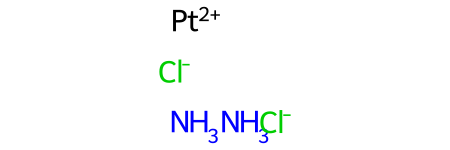

In [6]:
IDX = -1
print(good_smiles[IDX])
train_mol[IDX]

In [8]:
# Here I want to discard bad molecules

smiles_ok = []
smiles_invariant = []
smiles_invalid = []
for smiles in train_smiles:
    try:
        models.hgraph2graph.hgraph.MoleculeDataset([smiles], args.vocab, args.atom_vocab, 1)
        smiles_ok.append(smiles)
        smiles_invariant.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles)))
    except:
        smiles_invalid.append(smiles)

good_smiles = smiles_invariant

After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning 1 -> 1
After pruning

In [9]:
np.savetxt(fname='/home/adam/Projects/vadeers/data/Ready Datasets/Baseline Dataset/smiles_corrected.txt', X=smiles_ok, fmt='%s')
np.savetxt(fname='/home/adam/Projects/vadeers/data/Ready Datasets/Baseline Dataset/smiles_invalid.txt', X=smiles_invalid, fmt='%s')
np.savetxt(fname='/home/adam/Projects/vadeers/data/Ready Datasets/Baseline Dataset/smiles_corrected_rdkitinvariant.txt', X=smiles_invariant, fmt='%s')

In [10]:
model = HierVAE(args).cuda()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

print('Loading from checkpoint ' + args.generative_model)
model_state, optimizer_state, _, beta = torch.load(args.generative_model)
model.load_state_dict(model_state)
optimizer.load_state_dict(optimizer_state)

Loading from checkpoint ckpt/chembl-pretrained/model.ckpt


/home/adam/miniconda3/envs/hgraph2graph/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for epoch in range(args.epoch):
    good_smiles = sorted(set(good_smiles))
    random.shuffle(good_smiles)
    dataset = models.hgraph2graph.hgraph.MoleculeDataset(good_smiles, args.vocab, args.atom_vocab, args.batch_size)

    print(f'Epoch {epoch} training...')
    for _ in range(args.inner_epoch):
        meters = np.zeros(6)
        dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x:x[0], shuffle=True, num_workers=4)
        for batch in tqdm(dataloader):
            model.zero_grad()
            loss, kl_div, wacc, iacc, tacc, sacc = model(*batch, beta=beta)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            optimizer.step()
            meters = meters + np.array([kl_div, loss.item(), wacc.cpu() * 100, iacc.cpu() * 100, tacc.cpu() * 100, sacc.cpu() * 100])

        meters /= len(dataset)
        print("Beta: %.3f, KL: %.2f, loss: %.3f, Word: %.2f, %.2f, Topo: %.2f, Assm: %.2f, PNorm: %.2f, GNorm: %.2f" % (beta, meters[0], meters[1], meters[2], meters[3], meters[4], meters[5], param_norm(model), grad_norm(model)))

    ckpt = (model.state_dict(), optimizer.state_dict(), epoch, beta)
    torch.save(ckpt, os.path.join(args.save_dir, f"model.ckpt.{epoch}"))

    # Evaluate

    print(f'Epoch {epoch} decoding...')
    decoded_smiles = []
    with torch.no_grad():
        for _ in tqdm(range(args.nsample // args.batch_size)):
            outputs = model.sample(args.batch_size, greedy=True)
            decoded_smiles.extend(outputs)


After pruning 298 -> 289
Epoch 0 training...


 70%|██████▉   | 101/145 [00:41<00:20,  2.19it/s]

In [16]:
decoded_smiles[0] # ToDo extract my vobab from it, and add meaning of loss from from issues and make package work

'CCC(C)C(=O)NC(CO)C(C)C'

#### ToDo's:
1. The above loop works with SMILES strings provided as the default data set, but does not work with SMILES provided by Krzyś. This is an open issue in the repo and other people seem to struggle with it as well.

#### Questions?

1. It seems that fine-tuning uses raw SMILES as input while training from scratch requires a different loader with processed SMILES. Why is that?
2. What are the other metrics: `wacc`, `iacc`, `tacc`, `sacc`?